[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] [-1. -1. -1. ..., -1. -1.  1.] [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]] [-1. -1.  1. ..., -1. -1.  1.]
loss train: 32561.0
 loss test: 16281.0
total： 32561  error: 24720  acc rate: 0.2408095574460244
total： 16281  error: 12435  acc rate: 0.2362262760272711
loss train: 31936.8250882
 loss test: 15964.5159087
total： 32561  error: 7841  acc rate: 0.7591904425539756
total： 16281  error: 3846  acc rate: 0.7637737239727289
loss train: 31234.0090519
 loss test: 15607.8437463
total： 32561  error: 7841  acc rate: 0.7591904425539756
total： 16281  error: 3846  acc rate: 0.7637737239727289
loss train: 30595.917558
 loss test: 15284.4459402
total

total： 32561  error: 7841  acc rate: 0.7591904425539756
total： 16281  error: 3846  acc rate: 0.7637737239727289
loss train: 15612.0800734
 loss test: 7674.75752914
total： 32561  error: 7841  acc rate: 0.7591904425539756
total： 16281  error: 3846  acc rate: 0.7637737239727289
loss train: 15605.8803257
 loss test: 7671.26147722
total： 32561  error: 7841  acc rate: 0.7591904425539756
total： 16281  error: 3846  acc rate: 0.7637737239727289
Features: [-0.063674527278191201, -0.04478140348182582, -0.024174401822975849, -0.013223916731868526, -0.025705825384457988, -0.11412677292677173, -0.016648252669935474, 0.0034278449619666402, -0.0031880607860000931, -0.012463302449282629, -0.0064991167135085666, -0.00041206368390108404, 0.0, -0.036340169622657001, -0.033589345171364686, -0.035166082778191096, -0.03420660244761442, -0.032257777989672581, -0.0016261495622191164, -0.048300236533462382, -0.014763207870188923, -0.068285730910326706, 0.0026422988199205576, -0.0075257708504593065, -0.008972049

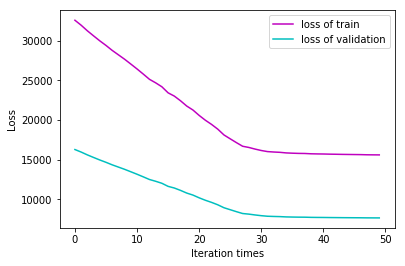

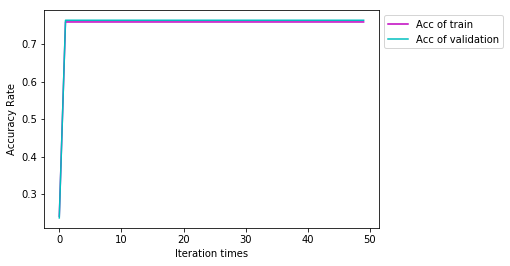

In [15]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

eta = 0.0001 # Learning Rate
iter =50 # Iteration times
accuracy = 0.001 # If loss<accuracy , then stop iteration
lam = 0.1 #lambda used in Loss Function

m_train = 32561 # Amount of training data
m_test = 16281 # Amount of testing data
features=123 # Fearures of dataset

#Initialize arrays
w= [0]*features  #All zero initialization

#used to stastic and draw graph
iter_num = [0]*iter;
loss_train  = [0]*iter;
loss_test  = [0]*iter;
acc_train = [0]*iter;
acc_test = [0]*iter;

#Use to get dataset from file
def get_data():
    data_train = load_svmlight_file("dataset\\a9a",n_features=features)
    X_train = data_train[0].toarray()
    y_train = data_train[1]
    data_test = load_svmlight_file("dataset\\a9a.t",n_features=features)
    X_test = data_test[0].toarray()
    y_test = data_test[1]
    return X_train, y_train, X_test, y_test

#Use to split dataset and return
def split_data():
    X, y = get_data()
    X = X.toarray()
    return train_test_split( X, y, test_size=0.5, random_state=43)

#Loss function  
def loss(m,X,y):
    loss = 0.0
    for i in range (0,m):
        y_predict = 0
        for j in range(0,features):
            y_predict = y_predict + X[i][j] * w[j]
        if(y[i]*y_predict-1<0):
            loss += (1-y[i]*y_predict)
    for  j in range (0,features):
        loss = loss + 0.5 * lam * w[j] * w[j]
    return loss


#Derivative the Loss function to get Gradient(G)
def derivative(m,X,y):
    y_predict = [0]*m 
    for i in range (0,m):
        y_predict[i] = 0
        for j in range(0,features):
            y_predict[i] = y_predict[i] + X[i][j] * w[j]
    
    grad = [0] * features
    for j in range(0,features):
        grad[j] = abs(lam*w[j])
        for i in range(0,m):
            if(y[i]*y_predict[i]-1<0):
                grad[j] = grad[j] - y[i] * X[i][j]
    return grad

#Derivative the Loss function to get Gradient(G)
def derivative_random(m,X,y):
    i = random.randint(0,m-1)
    y_predict = 0
    for j in range(0,features):
        y_predict = y_predict + X[i][j] * w[j]
    
    grad = [0] * features
    for j in range(0,features):
        grad[j] = abs(lam*w[j])
        if(y[i]*y_predict-1<0):
             grad[j] = grad[j] - y[i] * X[i][j]
    
    return grad

#Process Gradient descent to minimum the Loss
def update_random(m,X,y):
    # grad is the gradient G
    grad = derivative_random(m,X,y)
    for j in range(0,features):
         #" D = -G " is " - grad[j] " here
        w[j] = w[j] - eta*grad[j]


        
#Train and validate 
def trainAndTest():
    for i in range (0,iter):
        iter_num[i] = i;
        
                
        loss_train[i] = loss(m_train,X_train,y_train)
        print("loss train:",loss_train[i]);
        
        loss_test[i] = loss(m_test,X_test,y_test)
        print(" loss test:",loss_test[i]);
        
        acc_train[i] = accRate(m_train,X_train,y_train)
        acc_test[i] = accRate(m_test,X_test,y_test)
            
        for j in range (0,100):
            update_random(m_train,X_train,y_train)
        
        
#The linear model
def predict(x):
    pre = 0.0
    for j in range (0,features):
        pre = pre + x[j] * w[j]
    if(pre>=0) :
        return 1
    else:
        return -1

def accRate(m,X,y):
    error = 0
    for i in range(0,m):
        if(predict(X[i])!=y[i]):
            error+=1
    print("total：",m," error:",error," acc rate:",1.0 - error/m )
    return 1.0 - error/m
    
    
#Main 
X_train, y_train, X_test,y_test = get_data()
print(X_train, y_train, X_test,y_test)
trainAndTest()


#Print the information and draw graphs
print("Features:",w)
fig, ax = plt.subplots()
ax.plot(iter_num, loss_train,color = 'm', label='loss of train')
ax.plot(iter_num, loss_test, color = 'c', label='loss of validation')
plt.legend(bbox_to_anchor=[1, 1])  
ax.set_xlabel('Iteration times')
ax.set_ylabel('Loss')
plt.show()  

fig2, ax2 = plt.subplots()
ax2.plot(iter_num, acc_train,color = 'm', label='Acc of train')
ax2.plot(iter_num, acc_test, color = 'c', label='Acc of validation')
plt.legend(bbox_to_anchor=[1, 1])  
ax2.set_xlabel('Iteration times')
ax2.set_ylabel('Accuracy Rate')
plt.show()
        
